Iter     Function value   Gradient norm 
     0     8.295381e-01     1.708935e-01
 * time: 8.893013000488281e-5
     1     7.242501e-01     2.984255e-01
 * time: 46.10864186286926
     2     5.675569e-01     2.176152e-01
 * time: 107.57972478866577
     3     4.636836e-01     2.424029e-01
 * time: 169.12461185455322
     4     3.633995e-01     1.710499e-01
 * time: 215.1306929588318
     5     3.120026e-01     2.181452e-01
 * time: 261.21273493766785
     6     2.368131e-01     1.884285e-01
 * time: 307.34073400497437
     7     1.922078e-01     4.802704e-02
 * time: 337.9903838634491
     8     1.809641e-01     5.527517e-02
 * time: 384.0255079269409
     9     1.507253e-01     9.670096e-02
 * time: 429.9223828315735
    10     1.257590e-01     8.021201e-02
 * time: 476.06373596191406
    11     1.054336e-01     8.126496e-02
 * time: 522.1202318668365
    12     9.134175e-02     4.738744e-02
 * time: 568.0778889656067
    13     7.874116e-02     7.279546e-02
 * time: 614.1033158302307

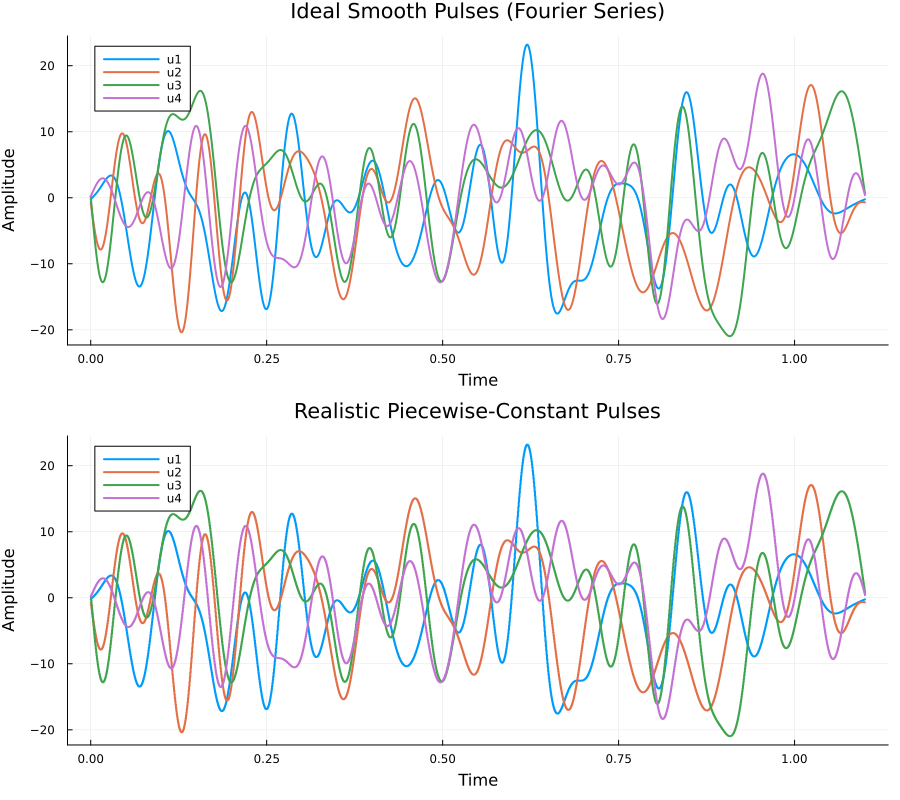

Final propagator matrix:
ComplexF64[0.31967348094663656 - 0.09791371136906771im 0.22341895786608834 - 0.19458399912274538im -0.3754388600087648 - 0.07334279036993945im -0.17390973975302956 - 0.18209823538977266im 0.22035211097719262 - 0.06195947092791686im 0.1120484575752093 + 0.49508141421060203im 0.22926749347230788 - 0.05421950550910572im -0.2942685094884181 - 0.24250248351821432im -0.09769225361232535 - 0.0755214009156601im -0.2491050235893813 + 0.04944359408978623im -0.0003547740102819368 - 0.0003180785086652435im -0.00014357386441215 + 0.00016441948235221526im 0.0003474748486608782 + 2.2963466726643922e-5im 0.00011094099733188409 + 3.5875591892608928e-6im 0.00015265290412309885 - 0.00016479373985927684im; -0.007711070171570916 + 0.38348674727654375im 0.2065102975869537 + 0.18846938770521024im -0.04115244929413929 + 0.13698481157460243im 0.22578149902082453 + 0.1290831228519333im -0.14670567582934935 - 0.33946898166296235im -0.10851262011081654 + 0.2116465375204306im 0.32331474965

In [3]:
using LinearAlgebra
using Random
using Optim
using Plots

function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end
function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c = 5)
ψ_cavidealpos   = zL_cavitypos(α; d_c = 5)

# Ground state |0>
ground_state = zeros(ComplexF64, 5)
excited_state = zeros(ComplexF64, 5)
ground_state[1] = 1.0 + 0im
excited_state[2] = 1.0 + 0im

# Avoid aliasing: make copies if you'll mutate these later
ψ_trainitialg = copy(ground_state[1:3]);
ψ_trainitiale = copy(excited_state[1:3]);

ψ_cavinitial = copy(ground_state);

ψ_inig = kron(ψ_trainitialg, ψ_cavinitial);
ψ_inie = kron(ψ_trainitiale, ψ_cavinitial);
ψ_Zgminus = kron(ψ_trainitialg, ψ_cavidealminus);
ψ_Zgpos = kron(ψ_trainitialg, ψ_cavidealpos);
ψ_Zeminus = kron(ψ_trainitiale, ψ_cavidealminus);
ψ_Zepos = kron(ψ_trainitiale, ψ_cavidealpos);

function make_system(; d_q=3, d_c=5)
    Iq = Matrix{ComplexF64}(I, d_q, d_q)
    
    a = zeros(ComplexF64, d_c, d_c)
    for n in 2:d_c
        a[n-1, n] = sqrt(n-1)
    end
    b = zeros(ComplexF64, d_q, d_q)
    for n in 2:d_q
        b[n-1, n] = sqrt(n-1)
    end
    a⁺ = a'
    b⁺ = b'
    Ic = Matrix{ComplexF64}(I, d_c, d_c)

    ω_T  = 5664.0 * 2 * pi
    ω_C  = 4452.6 * 2 * pi
    χ   = -2.194 * 2 * pi
    α   = -236.0 * 2 * pi
    k   = -0.0037 * 2 * pi
    χ′  = -0.019 * 2 * pi
    
    H_oscillator = (k/2) * kron(Iq, a⁺*a⁺*a*a)
    H_transmon   = (α/2) * kron(b⁺*b⁺*b*b, Ic)
    H_interaction = χ * kron(b⁺*b, a⁺*a) + (χ′/2) * kron(b⁺*b, a⁺*a⁺*a*a)
    H0 = H_oscillator + H_transmon + H_interaction
    
    Hx = kron(b + b⁺, Ic)
    Hy = kron(1im*(b⁺- b), Ic)
    HcX = kron(Iq, a + a⁺)
    HcY = kron(Iq, 1im*(a⁺ - a))
    
    return H0, [Hx, Hy, HcX, HcY], (d_q, d_c)
end

function fidelity_and_phase(U)
    d = size(U, 1)
    J = abs((ψ_Zgpos)'* U * ψ_Zgminus)^2 + abs((ψ_Zgminus)'* U * ψ_Zgpos)^2
    # Take the real part since J should be real for a proper fidelity measure
    J_real = real(J)
    F = J_real/2
    return F, J_real
end

function fourier_sine_bank(N, K)
    t = collect(0:N-1)
    M = zeros(Float64, K, N)
    for r in 1:K
        M[r, :] = sin.(π * r * t / N)
    end
    return M
end

function raised_cosine(N)
    return 0.5 * (1.0 .- cos.(2 * π * collect(0:N-1) / N))
end

function coeffs_to_pulses(theta, N, K; m=4)
    @assert length(theta) == m*(K+1)
    rc = raised_cosine(N)
    rc = 1
    S = K > 0 ? fourier_sine_bank(N, K) : zeros(Float64, 0, N)
    u_list = Vector{Vector{Float64}}()
    ofs = 1
    for _j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u = b0 .+ (K > 0 ? (br' * S)[:] : zeros(Float64, N))
        push!(u_list, (u .* rc))
        ofs += (K+1)
    end
    return u_list
end

function propagate_from_pulses(H0, H_controls, u_list, T)
    N = length(u_list[1])
    dt = T / N
    d = size(H0, 1)
    U = Matrix{ComplexF64}(I, d, d)
    m = length(H_controls)
    
    # Matrix exponential approach for piecewise-constant Hamiltonian
    for k in 1:N
        # Build constant Hamiltonian for this time segment
        H = copy(H0)
        for j in 1:m
            H += u_list[j][k] * H_controls[j]
        end
        
        # Exact evolution for constant Hamiltonian
        U = exp(-1im * H * dt) * U
    end
    
    return U
end

function nm_cost(theta, H0, H_controls, T, N, K; amp_clip=nothing, max_amp=5 * pi * 2, penalty_weight=1000.0)
    u_list = coeffs_to_pulses(theta, N, K, m=length(H_controls))
    
    # Calculate penalty for exceeding amplitude bounds
    penalty = 0.0
    for j in 1:length(u_list)
        violations = max.(abs.(u_list[j]) .- max_amp, 0.0)
        penalty += sum(violations.^2)
    end
    
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, _ = fidelity_and_phase(U)
    return 1.0 - F + penalty_weight * penalty
end

function run_lbfgs(T, N, phi; K=40, seed=42, init_scale=1.0 * 1 * (1 * pi),
                amp_clip=nothing, maxiter=700, f_abstol=1e-8, x_abstol=1e-8)
    H0, H_controls, _ = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    
    theta0 = Float64[]
    for _ in 1:m
        push!(theta0, 0.0)
        append!(theta0, init_scale * (2*rand(K) .- 1))
    end

    function objective(th)
        th_clipped = clamp.(th, -init_scale, init_scale)
        return nm_cost(th_clipped, H0, H_controls, T, N, K, amp_clip=amp_clip)
    end

    res = optimize(objective, theta0, Optim.LBFGS(),
                Optim.Options(iterations=maxiter, f_abstol=f_abstol, x_abstol=x_abstol, show_trace=true))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    
    u_list = coeffs_to_pulses(theta, N, K, m=m)
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, J = fidelity_and_phase(U)

    return Dict("theta" => theta, "u_list" => u_list, "U_final" => U,
            "F" => F, "J" => J, "res" => res)
end

function plot_pulses(u_list, T; title="Four-channel pulses (L-BFGS)")
    N = length(u_list[1])
    t = range(0.0, T, length=N)
    
    gr()
    
    # Create two subplots
    p1 = plot(size=(900, 400), title="Ideal Smooth Pulses (Fourier Series)")
    for (idx, u) in enumerate(u_list)
        plot!(p1, t, u, label="u$(idx)", linewidth=2)
    end
    xlabel!(p1, "Time")
    ylabel!(p1, "Amplitude")
    plot!(p1, grid=true, legend=:best)
    
    p2 = plot(size=(900, 400), title="Realistic Piecewise-Constant Pulses")
    for (idx, u) in enumerate(u_list)
        plot!(p2, t, u, label="u$(idx)", linewidth=2, linetype=:steppost)
    end
    xlabel!(p2, "Time")
    ylabel!(p2, "Amplitude")
    plot!(p2, grid=true, legend=:best)
    
    # Combine plots vertically
    p = plot(p1, p2, layout=(2, 1), size=(900, 800))
    
    display(p)
    savefig(p, "quantum_pulses.png")
    
    return p
end

function generate_pulses()
    T = 1.1
    phi = π
    N = 2000
    K = 40
    
    result = run_lbfgs(T, N, phi, K=K, seed=42, init_scale=1.0 * 1 * (1 * pi), maxiter=100, f_abstol=1e-8, x_abstol=1e-8)
    
    println("Final Fidelity: $(result["F"])")
    
    plot_pulses(result["u_list"], T, title="Optimized Control Pulses (L-BFGS)")
    
    return result
end

result = generate_pulses()
H0, H_controls, _ = make_system()
final_propagator = propagate_from_pulses(H0, H_controls, result["u_list"], 1)
println("Final propagator matrix:")
println(final_propagator)

Iter     Function value   Gradient norm 
     0     8.041789e-01     2.498398e-01
 * time: 0.0001900196075439453
     1     6.832663e-01     8.990701e-02
 * time: 513.9421548843384
     2     6.606574e-01     1.235762e-01
 * time: 1024.036278963089
     3     5.974068e-01     1.637815e-01
 * time: 1779.3638939857483
     4     5.507799e-01     2.582878e-01
 * time: 2542.004821062088
     5     4.746534e-01     1.193108e-01
 * time: 3334.219207048416
     6     4.355954e-01     7.741152e-02
 * time: 4130.629599094391
     7     4.204743e-01     1.684704e-01
 * time: 4888.952790975571
     8     3.951336e-01     1.248581e-01
 * time: 5634.300282001495
     9     3.774933e-01     5.448766e-02
 * time: 6364.891649007797
    10     3.682893e-01     7.657532e-02
 * time: 7099.201672077179
    11     3.554780e-01     6.593431e-02
 * time: 7885.2396941185
    12     3.374178e-01     5.884598e-02
 * time: 8671.035129070282
    13     3.249127e-01     7.418451e-02
 * time: 9487.771023988724
    

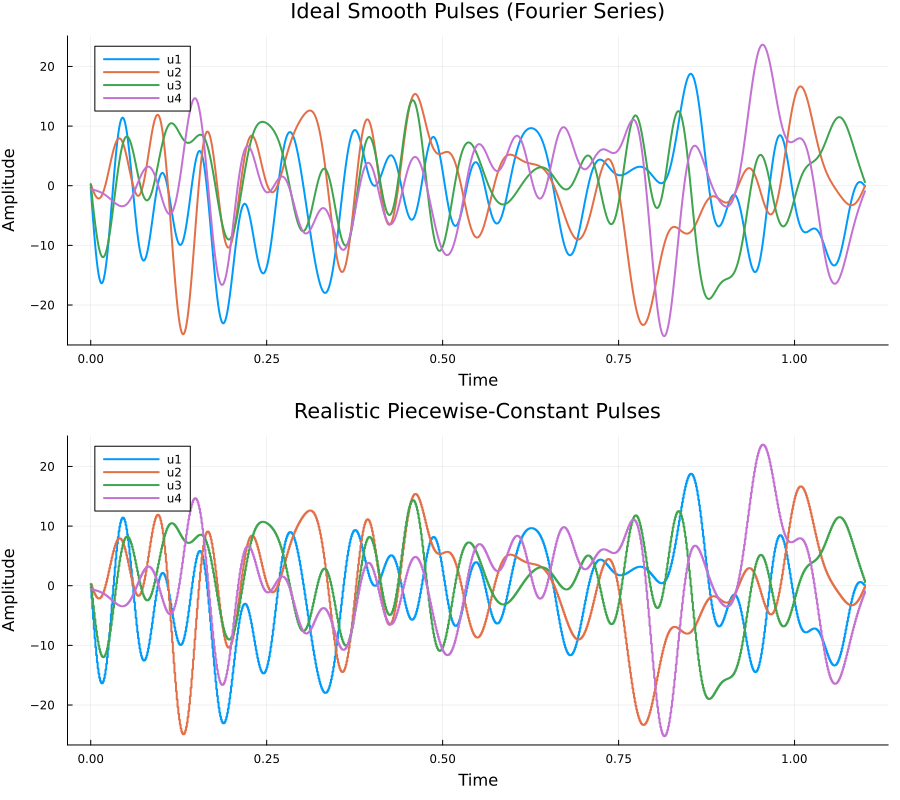

Final propagator matrix:
ComplexF64[0.027440114500995753 - 0.19006904698156957im -0.2843535935621597 - 0.3973338920818261im -0.3351008004443334 + 0.34754881951314465im 0.00018509429499807638 + 0.09574177608222288im 0.06767106050715055 + 0.024554717097749472im -0.00946336714228555 + 0.014271644654852462im -0.03489944411903497 + 0.01956855345814961im 0.02988743895455641 - 0.015257189533381222im 0.011202795725451627 - 0.0021884237623894195im 0.015854234886059762 + 0.0020335165682019013im 0.004030533642783443 - 0.0073568815091323im -0.0021964555488249824 - 0.004456182993483862im -0.002954206388299246 - 0.002575607039332965im -0.002200005051939173 - 0.0006677016873905037im -0.000396083057855794 + 0.0008006228309417963im 0.10228690277246924 + 0.39754001293339736im 0.33079623275133946 + 0.09808180942311105im -0.37848600590524656 - 0.009887345862069599im -0.027836609904780603 + 0.1467692545751876im -0.005906001136786108 + 0.042524631022118536im 0.00030424365910465876 + 0.08614760066320445im -0

In [5]:
using LinearAlgebra
using Random
using Optim
using Plots

function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end
function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c = 15)
ψ_cavidealpos   = zL_cavitypos(α; d_c = 15)

# Ground state |0>
ground_state = zeros(ComplexF64, 15)
excited_state = zeros(ComplexF64, 15)
ground_state[1] = 1.0 + 0im
excited_state[2] = 1.0 + 0im

# Avoid aliasing: make copies if you'll mutate these later
ψ_trainitialg = copy(ground_state[1:4]);
ψ_trainitiale = copy(excited_state[1:4]);

ψ_cavinitial = copy(ground_state);

ψ_inig = kron(ψ_trainitialg, ψ_cavinitial);
ψ_inie = kron(ψ_trainitiale, ψ_cavinitial);
ψ_Zgminus = kron(ψ_trainitialg, ψ_cavidealminus);
ψ_Zgpos = kron(ψ_trainitialg, ψ_cavidealpos);
ψ_Zeminus = kron(ψ_trainitiale, ψ_cavidealminus);
ψ_Zepos = kron(ψ_trainitiale, ψ_cavidealpos);

function make_system(; d_q=4, d_c=15)
    Iq = Matrix{ComplexF64}(I, d_q, d_q)
    
    a = zeros(ComplexF64, d_c, d_c)
    for n in 2:d_c
        a[n-1, n] = sqrt(n-1)
    end
    b = zeros(ComplexF64, d_q, d_q)
    for n in 2:d_q
        b[n-1, n] = sqrt(n-1)
    end
    a⁺ = a'
    b⁺ = b'
    Ic = Matrix{ComplexF64}(I, d_c, d_c)

    ω_T  = 5664.0 * 2 * pi
    ω_C  = 4452.6 * 2 * pi
    χ   = -2.194 * 2 * pi
    α   = -236.0 * 2 * pi
    k   = -0.0037 * 2 * pi
    χ′  = -0.019 * 2 * pi
    
    H_oscillator = (k/2) * kron(Iq, a⁺*a⁺*a*a)
    H_transmon   = (α/2) * kron(b⁺*b⁺*b*b, Ic)
    H_interaction = χ * kron(b⁺*b, a⁺*a) + (χ′/2) * kron(b⁺*b, a⁺*a⁺*a*a)
    H0 = H_oscillator + H_transmon + H_interaction
    
    Hx = kron(b + b⁺, Ic)
    Hy = kron(1im*(b⁺- b), Ic)
    HcX = kron(Iq, a + a⁺)
    HcY = kron(Iq, 1im*(a⁺ - a))
    
    return H0, [Hx, Hy, HcX, HcY], (d_q, d_c)
end

function fidelity_and_phase(U)
    d = size(U, 1)
    J = abs((ψ_Zgpos)'* U * ψ_Zgminus)^2 + abs((ψ_Zgminus)'* U * ψ_Zgpos)^2
    # Take the real part since J should be real for a proper fidelity measure
    J_real = real(J)
    F = J_real/2
    return F, J_real
end

function fourier_sine_bank(N, K)
    t = collect(0:N-1)
    M = zeros(Float64, K, N)
    for r in 1:K
        M[r, :] = sin.(π * r * t / N)
    end
    return M
end

function raised_cosine(N)
    return 0.5 * (1.0 .- cos.(2 * π * collect(0:N-1) / N))
end

function coeffs_to_pulses(theta, N, K; m=4)
    @assert length(theta) == m*(K+1)
    rc = raised_cosine(N)
    rc = 1
    S = K > 0 ? fourier_sine_bank(N, K) : zeros(Float64, 0, N)
    u_list = Vector{Vector{Float64}}()
    ofs = 1
    for _j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u = b0 .+ (K > 0 ? (br' * S)[:] : zeros(Float64, N))
        push!(u_list, (u .* rc))
        ofs += (K+1)
    end
    return u_list
end

function propagate_from_pulses(H0, H_controls, u_list, T)
    N = length(u_list[1])
    dt = T / N
    d = size(H0, 1)
    U = Matrix{ComplexF64}(I, d, d)
    m = length(H_controls)
    
    # Matrix exponential approach for piecewise-constant Hamiltonian
    for k in 1:N
        # Build constant Hamiltonian for this time segment
        H = copy(H0)
        for j in 1:m
            H += u_list[j][k] * H_controls[j]
        end
        
        # Exact evolution for constant Hamiltonian
        U = exp(-1im * H * dt) * U
    end
    
    return U
end

function nm_cost(theta, H0, H_controls, T, N, K; amp_clip=nothing, max_amp=5 * pi * 2, penalty_weight=1000.0)
    u_list = coeffs_to_pulses(theta, N, K, m=length(H_controls))
    
    # Calculate penalty for exceeding amplitude bounds
    penalty = 0.0
    for j in 1:length(u_list)
        violations = max.(abs.(u_list[j]) .- max_amp, 0.0)
        penalty += sum(violations.^2)
    end
    
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, _ = fidelity_and_phase(U)
    return 1.0 - F + penalty_weight * penalty
end

function run_lbfgs(T, N, phi; K=40, seed=42, init_scale=1.0 * 1 * (1 * pi),
                amp_clip=nothing, maxiter=700, f_abstol=1e-8, x_abstol=1e-8)
    H0, H_controls, _ = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    
    theta0 = Float64[]
    for _ in 1:m
        push!(theta0, 0.0)
        append!(theta0, init_scale * (2*rand(K) .- 1))
    end

    function objective(th)
        th_clipped = clamp.(th, -init_scale, init_scale)
        return nm_cost(th_clipped, H0, H_controls, T, N, K, amp_clip=amp_clip)
    end

    res = optimize(objective, theta0, Optim.LBFGS(),
                Optim.Options(iterations=maxiter, f_abstol=f_abstol, x_abstol=x_abstol, show_trace=true))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    
    u_list = coeffs_to_pulses(theta, N, K, m=m)
    if amp_clip !== nothing
        for j in 1:length(u_list)
            u_list[j] = clamp.(u_list[j], -amp_clip, amp_clip)
        end
    end
    U = propagate_from_pulses(H0, H_controls, u_list, T)
    F, J = fidelity_and_phase(U)

    return Dict("theta" => theta, "u_list" => u_list, "U_final" => U,
            "F" => F, "J" => J, "res" => res)
end

function plot_pulses(u_list, T; title="Four-channel pulses (L-BFGS)")
    N = length(u_list[1])
    t = range(0.0, T, length=N)
    
    gr()
    
    # Create two subplots
    p1 = plot(size=(900, 400), title="Ideal Smooth Pulses (Fourier Series)")
    for (idx, u) in enumerate(u_list)
        plot!(p1, t, u, label="u$(idx)", linewidth=2)
    end
    xlabel!(p1, "Time")
    ylabel!(p1, "Amplitude")
    plot!(p1, grid=true, legend=:best)
    
    p2 = plot(size=(900, 400), title="Realistic Piecewise-Constant Pulses")
    for (idx, u) in enumerate(u_list)
        plot!(p2, t, u, label="u$(idx)", linewidth=2, linetype=:steppost)
    end
    xlabel!(p2, "Time")
    ylabel!(p2, "Amplitude")
    plot!(p2, grid=true, legend=:best)
    
    # Combine plots vertically
    p = plot(p1, p2, layout=(2, 1), size=(900, 800))
    
    display(p)
    savefig(p, "quantum_pulses.png")
    
    return p
end

function generate_pulses()
    T = 1.1
    phi = π
    N = 1000
    K = 40
    
    result = run_lbfgs(T, N, phi, K=K, seed=42, init_scale=1.0 * 1 * (1 * pi), maxiter=100, f_abstol=1e-8, x_abstol=1e-8)
    
    println("Final Fidelity: $(result["F"])")
    
    plot_pulses(result["u_list"], T, title="Optimized Control Pulses (L-BFGS)")
    
    return result
end

result = generate_pulses()
H0, H_controls, _ = make_system()
final_propagator = propagate_from_pulses(H0, H_controls, result["u_list"], 1)
println("Final propagator matrix:")
println(final_propagator)